In [1]:
from astropy.io import fits
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D,SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
#plt.gray()
galaxy_name = 'NGC 2366'
'''
#entered by hand ------------------------------------------------------------------------------------------------------------------------------------------------
center_v = [430 , 500]
center_b = [430 , 504]
center_u = [380 , 530]
center = center_v
'''
# import files----------------------------------------------------------------------------------------------------------------------------------------------------
light_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data/NGC 2366/n2366u.fits")
light_u = light_file_u[0].data

light_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data/NGC 2366/n2366b.fits")
light_b = light_file_b[0].data

light_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy\Data/NGC 2366/n2366v.fits")
light_v = light_file_v[0].data

box_u = (1300 , 830)
box_b = (1300 , 850)
box_v = (1200 , 800)

lights = [light_u,light_b,light_v]
boxes = [box_u,box_b,box_v]
filters = ["U" , "B" , "V"]

print(np.shape(light_u),np.shape(light_b),np.shape(light_v))

(2048, 2048) (2048, 2048) (2048, 2048)


(2048, 2048) (2048, 2048) (2048, 2048)


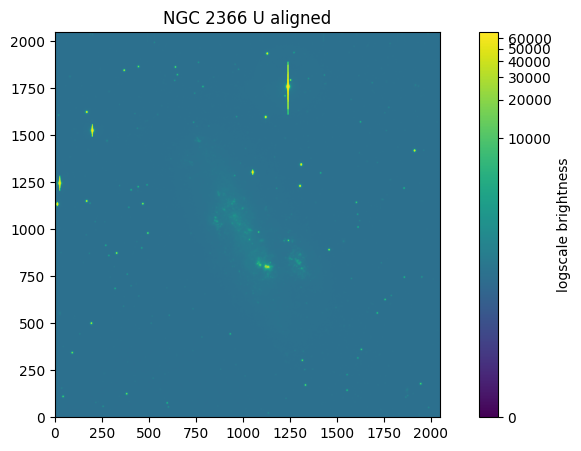

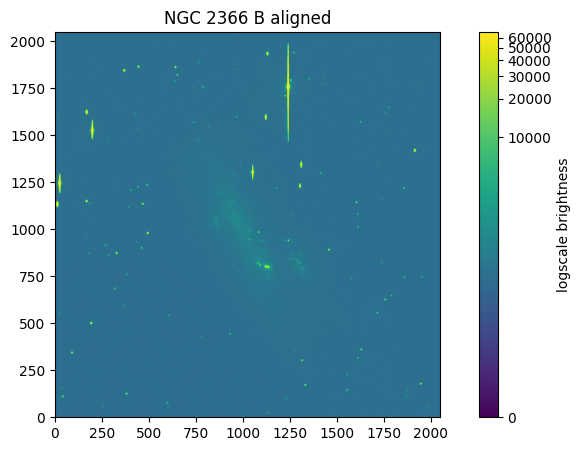

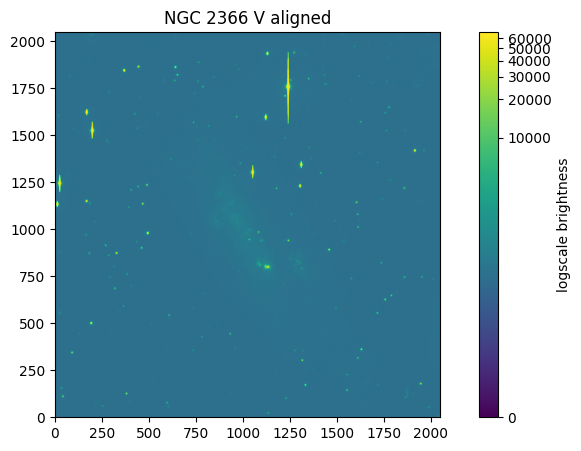

In [2]:
import astroalign as aa
target_fixed = lights[2].byteswap().newbyteorder('N')
source_fixed_1 = lights[0].byteswap().newbyteorder('N')
source_fixed_2 = lights[1].byteswap().newbyteorder('N')

registered_image_1, footprint_1 = aa.register(source_fixed_1, target_fixed)
registered_image_2,  footprint_2 = aa.register(source_fixed_2, target_fixed)
list_of_aligned_images = [registered_image_1, registered_image_2, lights[2] ]

print(np.shape(list_of_aligned_images[1]),np.shape(list_of_aligned_images[2]), np.shape(list_of_aligned_images[2]))
aligned = list_of_aligned_images

for i in range(0,3):
    ltf.log_scale_plot(aligned[i],"%s %s aligned"%(galaxy_name,filters[i]),"logscale brightness")

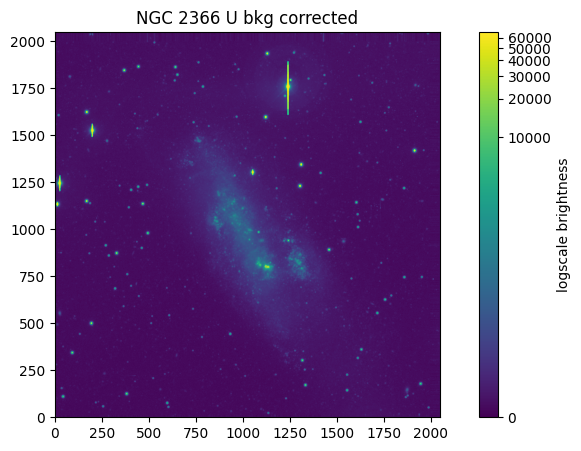

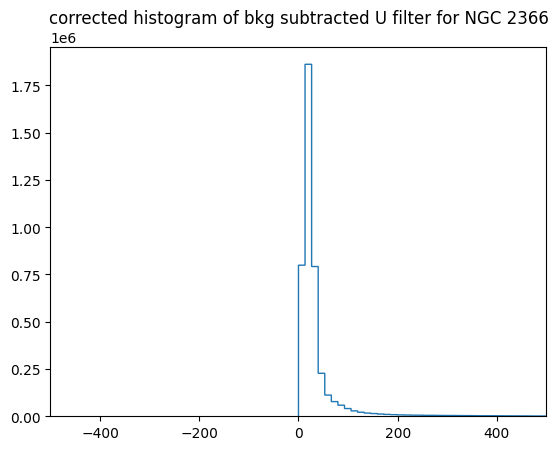

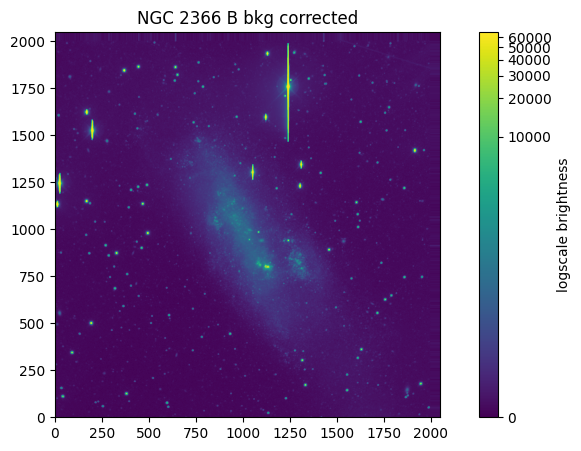

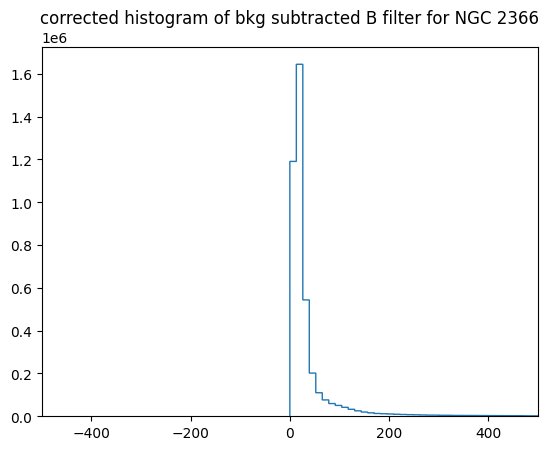

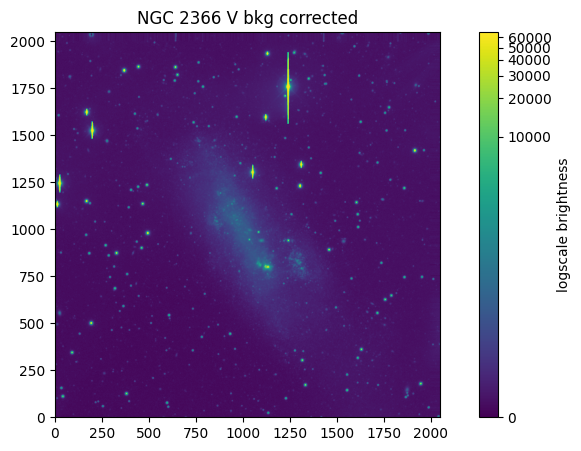

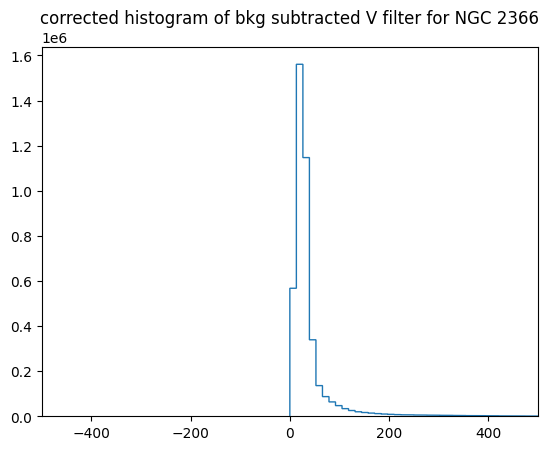

In [3]:
corrected = ltf.background_subtraction(aligned,3,boxes,(3,3))
for i in range(0,3):
    ltf.log_scale_plot(corrected[i],"%s %s bkg corrected"%(galaxy_name,filters[i]),"logscale brightness")
    output_filename = '%s_%s_background_subtracted.fits'%(galaxy_name,filters[i])
    # Create a PrimaryHDU (header/data unit) from your array
    primary_hdu = fits.PrimaryHDU(corrected[i])
    # Create an HDUList and append the PrimaryHDU
    hdul = fits.HDUList([primary_hdu])
    # Write the HDUList to the FITS file
    #hdul.writeto(output_filename, overwrite=True)
    counts, bins = np.histogram(corrected[i], 5000)
    plt.stairs(counts, bins)
    plt.xlim([-500, 500])
    plt.title("corrected histogram of bkg subtracted %s filter for %s" %(filters[i] , galaxy_name))
    plt.show()

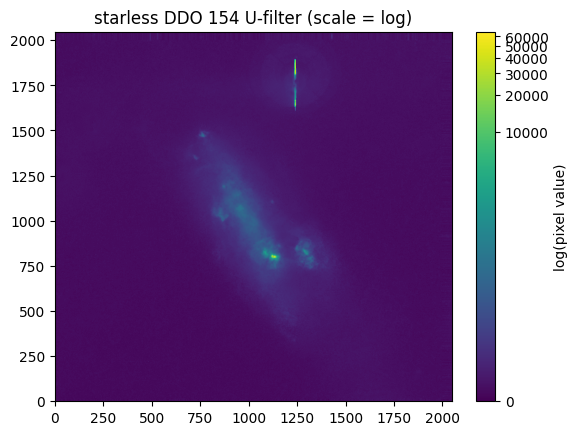

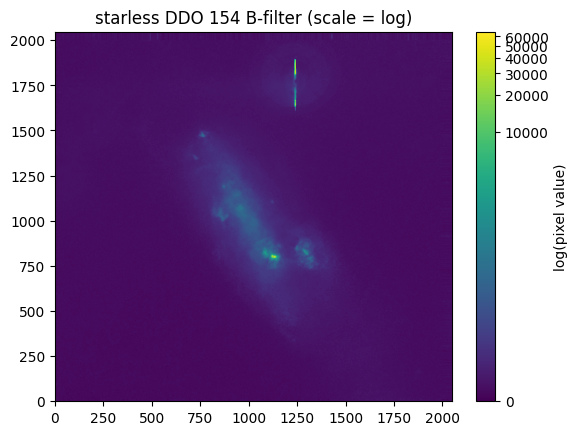

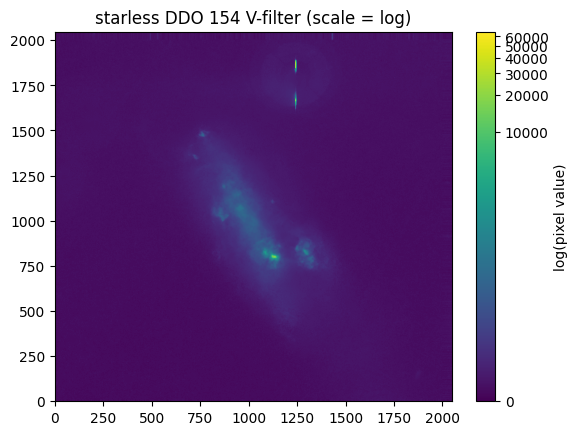

In [4]:
# import starless files----------------------------------------------------------------------------------------------------------------------------------------------------
starless_file_u = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code/n2366\starless\starless_NGC 2366_U_background_subtracted.fit")
starless_u = starless_file_u[0].data
starless_u[starless_u <= 0] = 1
starless_file_b = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code/n2366\starless\starless_NGC 2366_B_background_subtracted.fit")
starless_b = starless_file_b[0].data
starless_b[starless_b <= 0] = 1
starless_file_v = fits.open(r"C:/Users\AYSAN\Desktop/project/Galaxy/Code/n2366\starless\starless_NGC 2366_V_background_subtracted.fit")
starless_v = starless_file_v[0].data
starless_v[starless_v <= 0] = 1

starless = [starless_u , starless_b , starless_v]

norm = ImageNormalize(vmin=0., stretch=LogStretch())
for i in range(0 , len(starless)):
    
    plt.imshow(starless[i] , origin = "lower" , aspect='auto', norm = norm)
    plt.title('starless DDO 154 %s-filter (scale = log)'%(filters[i]))
    cbar = plt.colorbar()
    cbar.set_label('log(pixel value)')
    plt.show()

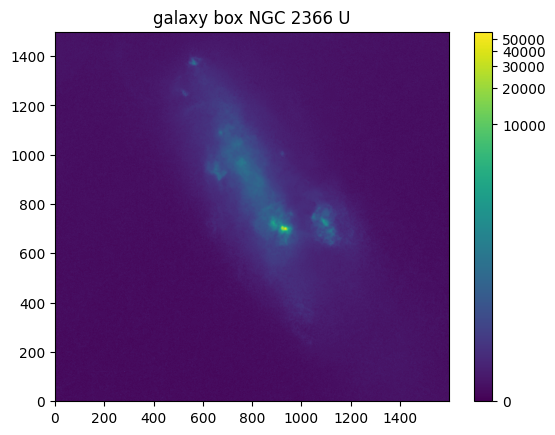

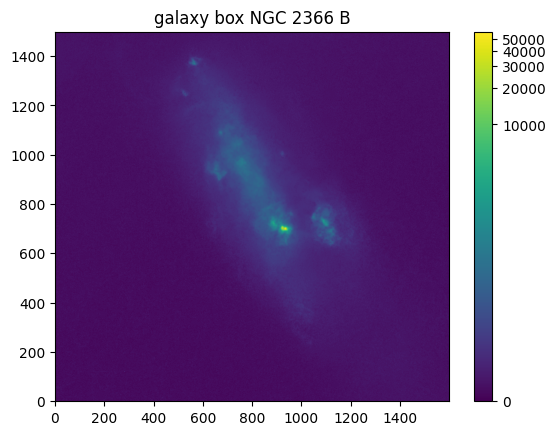

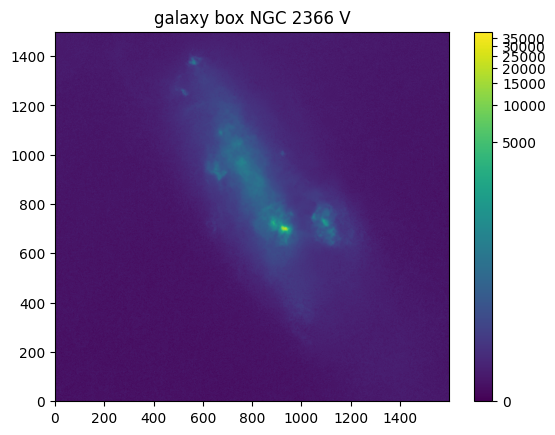

In [5]:
import little_things_functions as ltf
#galaxy_boxes = ltf.get_boxes(starless,[1000,850],1500)

box_size_x = 800
box_size_y = 750
box_center = [1000,850]

galaxy_boxes = []
for i in range(0 , len(starless)):
        box = starless[i][box_center[1] - box_size_y : box_center[1] + box_size_y, box_center[0] - box_size_x : box_center[0] + box_size_x]
        galaxy_boxes.append(box)

for i in range(0,3):
    norm = ImageNormalize(vmin=0., stretch=LogStretch())
    plt.imshow(galaxy_boxes[i], origin = "lower",norm = norm)
    plt.title("galaxy box %s %s"%(galaxy_name,filters[i]))
    plt.colorbar()
    plt.show()
     

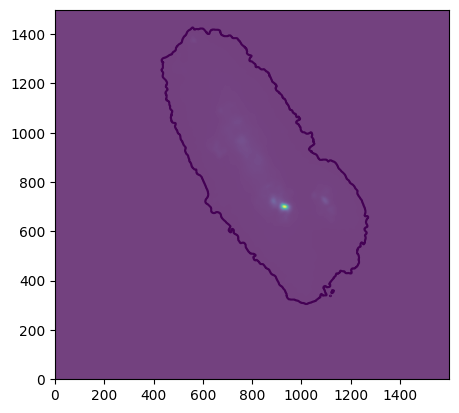

In [6]:
v_value_box = galaxy_boxes[2]
contour_points = ltf.contour_lines_coordinates(v_value_box, 5, [40])
x_points , y_points = contour_points

(818.8919870102329, 838.1858441776333)
[8.47476668e+02 8.56673672e+02 2.55423594e+02 6.33395614e+02
 5.75825318e-01]


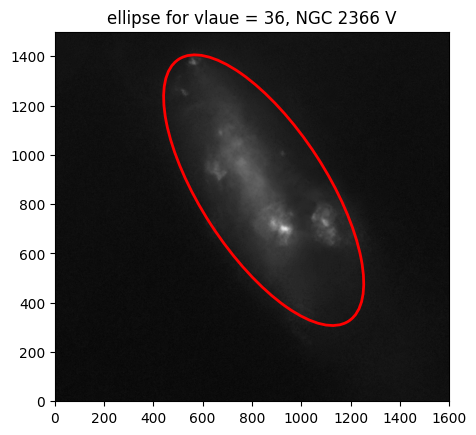

In [7]:
image_center_of_mass = ndimage.center_of_mass(v_value_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image

norm = ImageNormalize(vmin=0., stretch=LogStretch())
ax.imshow(v_value_box, cmap='gray' , origin = "lower", norm = norm)

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_value_box.shape[1])
ax.set_ylim(0,v_value_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for vlaue = 36, NGC 2366 V")
# Show the plot
plt.show()

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_18132\475637852.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import aperture_photometry


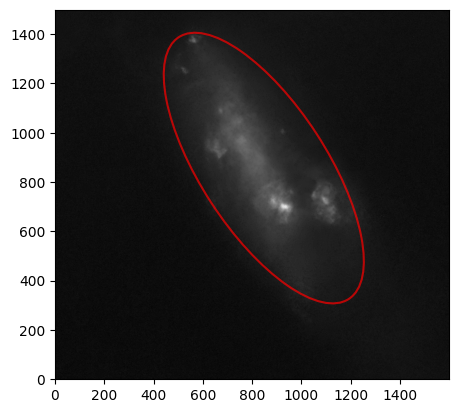

In [8]:
from astropy.coordinates import Angle
from photutils.aperture import EllipticalAperture
from photutils import aperture_photometry
elliptical_center_box = (xc,yc)
new_xc = xc +140
new_yc = yc +140
elliptical_center = (xc,yc)
ellipse_aper = EllipticalAperture(elliptical_center, a, b, theta= theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(v_value_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.show()
phot_table = aperture_photometry(v_value_box, ellipse_aper)
aperture_sum_A = phot_table['aperture_sum'][0] 

C:\Users\AYSAN\AppData\Local\Temp\ipykernel_18132\3187374063.py:3: DeprecationWarning: `photutils.EllipticalAperture` is a deprecated alias for `photutils.aperture.EllipticalAperture` and will be removed in the future. Instead, please use `from photutils.aperture import EllipticalAperture` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry
C:\Users\AYSAN\AppData\Local\Temp\ipykernel_18132\3187374063.py:3: DeprecationWarning: `photutils.aperture_photometry` is a deprecated alias for `photutils.aperture.aperture_photometry` and will be removed in the future. Instead, please use `from photutils.aperture import aperture_photometry` to silence this warning.
  from photutils import EllipticalAperture, aperture_photometry


Aperture sums: [9.73893722612836e-10, 31721.02826632434, 132967.52281922926, 310039.7309495752, 563377.9468146439, 891790.559436499, 1286692.23980771, 1742636.4592921287, 2257193.6240556603, 2823894.86986217, 3449303.558794035, 4149229.4354230845, 4933996.136020223, 5766554.082475933, 6681614.448111266, 7698980.268970651, 8817734.912050562, 10063063.322978638, 11431278.84894469, 13013074.37461488, 15629556.70249261, 19910918.474487092, 22401151.886846043, 24010825.077788558, 25340169.838350408, 26556969.090373795, 27713874.751836833, 28822308.75346687, 29897773.04644256, 30935414.523975946, 31967669.30379973, 32987901.631935313, 33986055.85576222, 35006282.775685765, 36006435.60009406, 36967615.28135692, 37919231.64714168, 38886232.80793886, 39870204.239550985, 40860124.85278751, 41834876.41363282, 42780396.66904687, 43714403.607717924, 44644766.28013321, 45598992.95563365, 46618056.43357648, 47689741.14035058, 48737803.62523629, 49752417.28074441, 50726244.807096615, 51665428.02407195

Text(0.5, 1.0, ' curve of growth for DDO168')

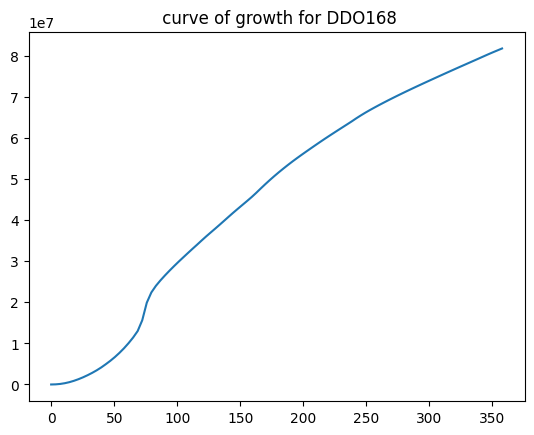

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import EllipticalAperture, aperture_photometry

# Assuming you have defined 'a', 'b', 'theta', 'elliptical_center', and 'v_value_box'
ab_ratio = a / b
ba_ratio = b / a
a_list = np.linspace(0, 1.4* a, 100)
b_list = ba_ratio * a_list

plus = 100
bigger_v_box = starless[2][box_center[1] - (box_size_y+plus) : box_center[1] + (box_size_y+plus), box_center[0] - (box_size_x+plus) : box_center[0] + (box_size_x+plus)]
new_xc = xc + int(plus)
new_yc = yc + int(plus)
elliptical_center = (new_xc,new_yc)

sum_values = []

for i in range(len(a_list)):
    # Ensure positive scalar values for major and minor axes
    a_i = max(a_list[i], 1e-6)  # Avoid zero or negative values
    b_i = max(b_list[i], 1e-6)
    ellipse_aper = EllipticalAperture(elliptical_center, a_i, b_i, theta)
    '''
    plt.imshow(bigger_v_box, cmap='gray', norm = norm, origin="lower")  # Replace 'image_data' with your data
    ellipse_aper.plot(color='red', lw=1.5, alpha=0.7)  # Overlay the aperture
    plt.show()
    '''
    # Compute the aperture sum
    phot_table = aperture_photometry(bigger_v_box, ellipse_aper)
    aperture_sum_A = phot_table['aperture_sum'][0]
    sum_values.append(aperture_sum_A)

print("Aperture sums:", sum_values)

plt.plot(a_list , sum_values)
plt.title(" curve of growth for DDO168")

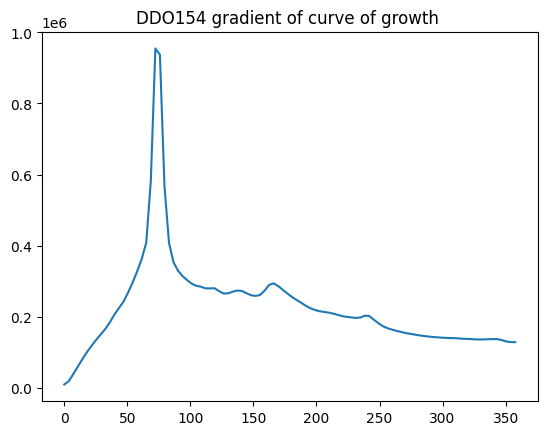

72.24101653119048
Minimum after peak: 127811.6027815896 at index 99
galaxy parameter a =  357.5930318293929 and galaxy parameter b =  886.7538592934621


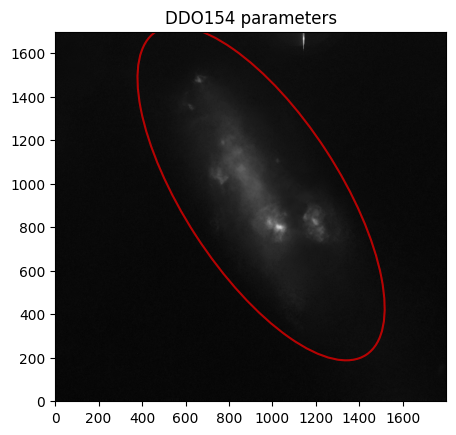

In [10]:
gradient_sum = np.gradient(sum_values, a_list)
plt.plot(a_list, gradient_sum)
plt.title( "DDO154 gradient of curve of growth ")
plt.show()
import numpy as np
from scipy.signal import find_peaks
peaks, _ = find_peaks(gradient_sum)

peak_index = peaks[0]
print(a_list[peak_index])
min_after_peak = np.min(gradient_sum[peak_index + 1:])

min_index_after_peak = np.where(gradient_sum == min_after_peak)[0][0]

print(f"Minimum after peak: {min_after_peak} at index {min_index_after_peak}")

galaxy_parameter_a = a_list[min_index_after_peak]
galaxy_parameter_b = galaxy_parameter_a*ba_ratio

print("galaxy parameter a = ", galaxy_parameter_a, "and galaxy parameter b = " , galaxy_parameter_a*ba_ratio)

ellipse_aper = EllipticalAperture(elliptical_center, galaxy_parameter_a, galaxy_parameter_b, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper.plot(color='red', lw=1.5, alpha=0.7) 
plt.title( "DDO154 parameters")
plt.show()

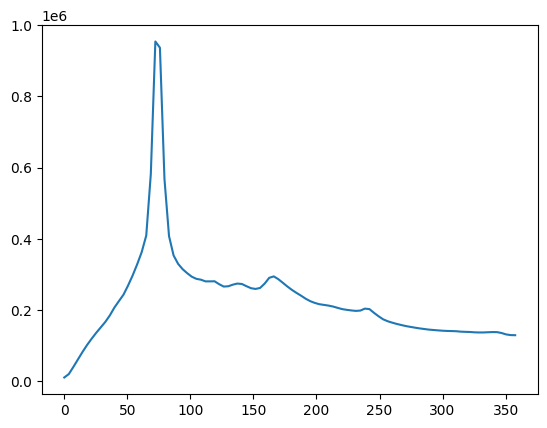

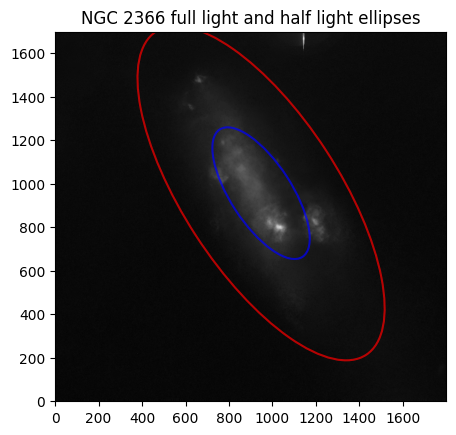

galaxy parameter a =  357.5930318293929 and galaxy parameter b =  886.7538592934621
galaxy count 81791916.38374294
galaxy half light a =  140.86998223582142 and galaxy half light b =  349.327277903485
half light count 40860124.85278751
0.4995618963258442


In [11]:
gradient_sum = np.gradient(sum_values, a_list)
plt.plot(a_list, gradient_sum)
plt.show()
import numpy as np
from scipy.signal import find_peaks
peaks, _ = find_peaks(gradient_sum)
peak_index = peaks[0]
min_after_peak = np.min(gradient_sum[peak_index + 1:])
min_index_after_peak = np.where(gradient_sum == min_after_peak)[0][0]

galaxy_parameter_a = a_list[min_index_after_peak]
galaxy_parameter_b = galaxy_parameter_a*ba_ratio

whole_galaxy = sum_values[min_index_after_peak]

half_light_estimated = whole_galaxy/2
half_light_index = min(range(len(sum_values)), key=lambda i: abs(sum_values[i] - half_light_estimated))

a_half_light = a_list[half_light_index]
b_half_light = a_half_light * ba_ratio

ellipse_aper_full_light = EllipticalAperture(elliptical_center, galaxy_parameter_a, galaxy_parameter_b, theta)
ellipse_aper_half_light = EllipticalAperture(elliptical_center, a_half_light, b_half_light, theta)
norm = ImageNormalize(vmin=0., stretch=LogStretch())
plt.imshow(bigger_v_box, cmap='gray', origin = "lower" , norm = norm) 
ellipse_aper_full_light.plot(color='red', lw=1.5, alpha=0.7) 
ellipse_aper_half_light.plot(color='blue', lw=1.5, alpha=0.7)
plt.title("%s full light and half light ellipses" %(galaxy_name))
plt.show()

print("galaxy parameter a = ", galaxy_parameter_a, "and galaxy parameter b = " , galaxy_parameter_b)
print("galaxy count", sum_values[min_index_after_peak])
print("galaxy half light a = ", a_half_light, "and galaxy half light b = " , b_half_light)
print("half light count", sum_values[half_light_index])
ratio = sum_values[half_light_index]/whole_galaxy
print(ratio)

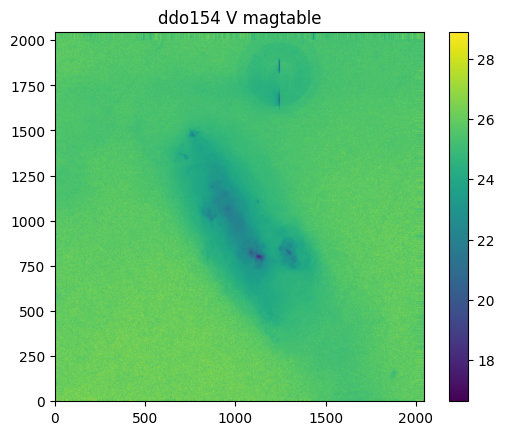

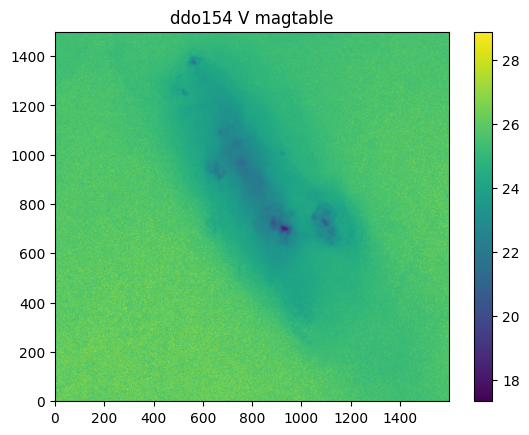

In [12]:
airmass_values=[1.32, 1.26, 1.25]
exposures = [1800, 480, 180]
pixel_scale = 0.42
mU_values = [1.679049,0.3572555,-0.0400845,0.]
mB_values = [-0.0829096,0.2040792, -0.005089185, 0.]
mV_values = [-0.3681273, 0.2220466, 0.0130948, 0.]
m_values = [mU_values,mB_values,mV_values]

plt.imshow(ltf.mag_table_correction(starless,airmass_values,m_values,pixel_scale, exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

plt.imshow(ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale, exposures)[2] , origin="lower")
plt.title("ddo154 V magtable")
plt.colorbar()
plt.show()

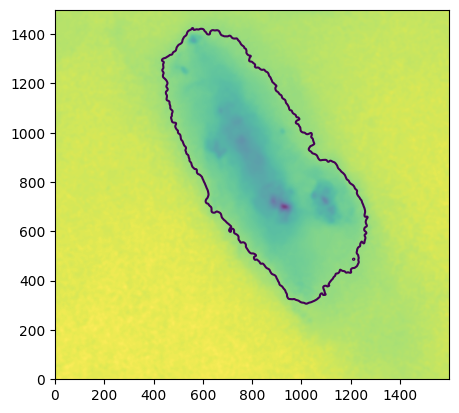

In [13]:
v_box = ltf.mag_table_correction(galaxy_boxes,airmass_values,m_values,pixel_scale,exposures)[2]
contour_points = ltf.contour_lines_coordinates(v_box, 5, [24.8])
x_points , y_points = contour_points

In [14]:
image_center_of_mass = ndimage.center_of_mass(v_box)
print(image_center_of_mass)
#coordinates
x, y = image_center_of_mass[1], image_center_of_mass[0]

(745.4176819893132, 797.1015612011716)


[8.47900844e+02 8.56233492e+02 2.54202402e+02 6.31960145e+02
 5.75724118e-01]


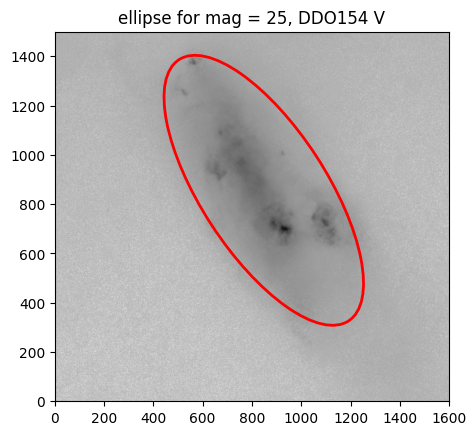

In [15]:
from scipy.ndimage import gaussian_filter
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse

initial_guess = [745, 747, (max(x_points) - min(x_points)) / 2 , (max(y_points) - min(y_points)) / 2 , 0]
popt, pcov = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
stdv=np.sqrt(np.diag(pcov))
stdvx=stdv[0]
stdvy=stdv[1]
stdva=stdv[2]
stdvb=stdv[3]
stdvpa=stdv[4]

xc, yc, a, b, theta = popt

curve = ltf.ellipse(x_points,popt[0],popt[1],popt[2],popt[3],popt[4])

# Assuming you have already defined xc, yc, a, b, and theta

xc, yc, a, b, theta = popt
print(popt)
# Create a figure and axis
plt.figure()
ax = plt.gca()

# Display the other image
ax.imshow(v_box, cmap='gray' , origin = "lower")

# Create the ellipse
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='r', facecolor='none', linewidth=2)

# Add the ellipse to the axis
ax.add_patch(ellipse)

# Set axis limits (adjust as needed)
ax.set_xlim(0,v_box.shape[1])
ax.set_ylim(0,v_box.shape[0])  # Reverse y-axis for imshow
plt.title("ellipse for mag = 25, DDO154 V")
# Show the plot
plt.show()